#Формулировка задания
Написать решение по извлечению сущностей из документов (новостных текстов).

В качестве датасета возьмите русские новости из **Balto-Slavic Natural Language Processing 2019 (helsinki.fi).**

Интересующие сущности: \
**PER(человек), ORG(организация), LOC(местоположение), EVT(события), PRO(продукты)**

# Задание 1

**Опишите задачу с точки зрения NLP. Что это за задача, какие классические методы существуют для ее решения? Как ее можно решать через LLM? Как обычно оценивают качество моделей в этой задаче?**

###**Задача**
Дана классическая задача NER(Named-entity recognition) - извлечение именованных сущностей из текста.

###**Классический метод**
Данная задача существует достаточно большой промежуток времени (лет 25-30) и сегодня сформировались некоторые классические методы её решения.

Задача сводится к задаче классификации отдельного токена предложения, где токен - слово. В основном классификация токенов происходит по схеме **BIOES**. \

**B** - Первый токен в именнованой сущности.\
**I** - Токены, размещающиеся в середине именованной сущности\
**E** - Последний токен именованной сущности\
**S** - Single, если сущность состоит из одного слова\
**O** - Токен не является именованной сущностью\
Например, предложение\
**"Копылов Михаил Юрьевич учится в МАИ"**, можно разбить таким образом:\
B-PER, I-PER, E-PER, O, O, S-ORG

Вполне очевидное замечание в данной схеме, что **I** не может стоять до **B**,
для разрешение данной задачи используется CRF(conditional random fields), если не вдаваться в подробности, то это графовая модель, которая учитывает зависимости между метками предсказания.

Основа классической модели для данной задачи является двунаправленные рекуррентные сети (BLSTM или BGRU), которые можно заменить трансформерами

###**Неклассический метод**
Данную задачу можно решить большой языковой моделью, по собственным ощущениям, такое решение может выдать довольно хорошую точность. В качестве запроса в LLM можно прислать заголовок и текст новости, и сформулировать задачу нахождения сущностей. Учитывая то, что LLM демонстрируют значительные общие знания о мире и способны запоминать большое количество фактов данная задача должна хорошо решаться. Впринципе, в данном ноутбуке мы это проверим.

###**Оценка решения**

Так как задача сводится к задаче классификации, то можно использовать оценки, которые используются в задаче классификации, т.е.

$$
Precision = \frac{TP}{TP + FP},
$$
Сумма правильно угаданных сущностей типа $\{entity\}\_\{Named-entity\}$ с правильным ответом деленное на сумму сущностей определенных моделью.

$$
Recall = \frac{TP}{TP + FN}
$$
Сумма правильно угаданных сущностей деленное на сумму сущностей в истинном ответе.

$$
F_{\beta} = \frac{(1+\beta^2)\cdot precision\cdot recall}{(\beta^2 \cdot precision) + recall}
$$
F - мера как гармоническое среднее между precision и recall

# Задание 2

**Реализуйте чтение датасета в pandas DataFrame с обязательными колонками "document_id", "document_text", "entity", "gold_answer". Выведите шапку датафрейма.**

In [73]:
!unzip -q /content/sample_pl_cs_ru_bg

In [74]:
import os
import pandas as pd
import numpy as np
from typing import List

DATA_PATH = "/content/sample_pl_cs_ru_bg"
RAW_PATH = DATA_PATH + "/raw/ru"
ANNOTATED_PATH = DATA_PATH + "/annotated/ru"

In [75]:
def preprocessing_entity_names(data: List[str]) -> tuple[List[str], List[str]]:
    """
    Обработка имен сущностей из предоставленных данных. Обработка включает в себя
    приведение названий к единому виду и замена некоторых категорий

    parameters:
        data (list): Список строк, которые содержат данные в формате
                      ["ru_{id}", "{Имя}\t{Нормальная словоформа}\t{Категория}\t{Тэг}", ..., ...]

    returns:
        tuple[list, list]: Кортеж из двух списков:
                - Обработанные категории сущностей
                - Уникальные именованные сущностей в формате "{Категория}_{Нормальная словоформа}"
    """
    arr_entity = []
    for row in data[1:]:
        row = row.split("\t")
        if len(row) == 1:
            continue
        if row[1] == "":
            arr_entity.append(row[2]+"_"+row[0])
        else:
            arr_entity.append(row[2]+"_"+row[1])
    arr_entity = [name.replace("GPE", "LOC", 1) for name in list(np.unique(arr_entity))]

    categories = [name[:3] for name in arr_entity if name[:3] != "GPE"]
    return arr_entity, list(np.unique(categories))


In [76]:
data_text = {"document_id":[], "document_text":[]}
data_annot = {"document_id": [], "entity":[], "gold_answer": []}

for i in range(len(os.listdir(RAW_PATH))):
    with open(RAW_PATH+"/"+os.listdir(RAW_PATH)[i]) as text_file:
        data_file = text_file.read().split("\n")
        data_text["document_id"].append(int(data_file[0][3:]))
        data_text["document_text"].append("\n".join(data_file[4:]))

    with open(ANNOTATED_PATH + "/" + os.listdir(ANNOTATED_PATH)[i]) as annotate_file:
        data_ann_file = annotate_file.read().split("\n")
        data_annot["document_id"].append(int(data_ann_file[0][3:]))
        entity_names, categories = preprocessing_entity_names(data_ann_file)

        data_annot["entity"].append(", ".join(categories))
        data_annot["gold_answer"].append(", ".join(entity_names))

df = pd.DataFrame.from_dict(data_text)
df = df.join(pd.DataFrame.from_dict(data_annot).set_index("document_id"), on = "document_id")

In [77]:
df.head()

,document_id,document_text,entity,gold_answer
0,1017,Борис Джонсон подал в отставку с поста министр...,"EVT, LOC, ORG, PER, PRO","EVT_Brexit, LOC_Великобритания, LOC_КИЕВ, ORG_..."
1,1003,09.07.2018 17:02 : Министр иностранных дел Вел...,"EVT, LOC, ORG, PER","EVT_брекзит, LOC_Великобритания, LOC_Даунинг-С..."
2,1006,Захарова лирически прокомментировала отставку ...,"EVT, LOC, ORG, PER, PRO","EVT_Brexit, LOC_Британия, LOC_Великобритания, ..."
3,10,Тереза Мэй рассчитывает усидеть в седле до зав...,"EVT, LOC, ORG, PER","EVT_Brexit, EVT_брекзит, EVT_брексит, LOC_Альб..."
4,1002,09.07.2018 18:09 : Премьер-министр Великобрита...,"EVT, LOC, ORG, PER","EVT_Брекзит, LOC_Великобритания, ORG_ЕС, ORG_Е..."


# Задание 3
**Напишите функцию, которая принимает на вход строку датафрейма и выдает текст входного сообщения для LLM.**


После нескольких экспериментов "за кадром" я пришел к выводу, что лучше использовать не весь текст документа, а присылать его по предложениям

Такая структура запросов используется для бОльшей устойчивости ответов от модели и так же обойти "неудобные" темы модели, когда она не могла анализировать весь текст из-за стоп слов в документе, если же отправлять по предложениям, то только предложения со стоп-словами игнорируются, а остальной документ - нет

In [90]:
def preprocessing_text(row: pd.core.series.Series, user_prompt: str, limit: int = 3) -> list[str]:
    """
    Создание промптов для LLM. Разбиение текста на предложения

    parameters:
        row (pd.core.series.Series): Строка данных
        user_prompt (str): Строка-шаблон для формирования промпта
        limit (int): Минимальный лимит на размер предложения по словам

    returns:
        list[str]: Список промптов
    """

    if "document_text" not in row:
        raise ValueError("Колонка 'document_text' отсутсвует в переданной строке данных")

    prompts = []
    sentences = row['document_text'].split(".")
    for sentence in sentences:
        if len(sentence.split(" ")) < limit:
            continue
        news_text = f"{sentence}"
        prompts.append(user_prompt.format(text = news_text))
    return prompts

In [91]:
user_prompt = "Ниже дан текст, найди все именованные объекты: EVT(именованные мероприятия), PER(имена людей), ORG(названия организаций), \
LOC(местоположение, страны), PRO(продукты компаний). Не пиши лишних слов, все сущности перечисли через запятую. \
Формат:'LOC_Россия, PER_Копылов Михаил, PRO_Facebook'\n TEXT: {text:s}"

preprocessing_text(df.iloc[0], user_prompt)[2]

"Ниже дан текст, найди все именованные объекты: EVT(именованные мероприятия), PER(имена людей), ORG(названия организаций), LOC(местоположение, страны), PRO(продукты компаний). Не пиши лишних слов, все сущности перечисли через запятую. Формат:'LOC_Россия, PER_Копылов Михаил, PRO_Facebook'\n TEXT:  Борис Джонсон подал в отставку с поста министра иностранных дел Великобритании"

# Задание 4
**Получите ответы GigaChat для всех документов. Документов всего 9, поэтому сделать это можно вручную, пользуясь веб-интерфейсом GigaChat или ботом в ВК или Телеграме. Не очищайте историю сообщений, чтобы потом продемонстрировать подлинность ответов на онлайн-собеседовании.
Внесите ответы GigaChat в датафрейм, сохраните его.**


In [81]:
!pip -q install gigachain
!pip -q install gigachat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.2/306.2 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.9 MB/s eta 0:00:00


In [82]:
from langchain.schema import HumanMessage, SystemMessage
from langchain.chat_models.gigachat import GigaChat
import re

def gigachat_request(chat, user_input: List[str], history_messages: List) -> tuple[List[str], List]:
    """
    Запрос к LLM GigaChat

    parameters:
        chat: Модель
        user_input (List[str]): Список пользовательских запросов
        history_messages (List): Список предыдущих сообщений в чате

    returns:
        tuple[List[str], List]:
              - Ответы модели
              - История сообщений
    """
    answer_request = []
    for prompt in user_input:
        history_messages.append(HumanMessage(content = prompt))
        res = chat(history_messages)
        history_messages.append(res)
        if res.response_metadata["finish_reason"] == "blacklist" or res.content == "EMPTY":
            continue
        answer_request += re.split(", |\n", res.content)

    return [", ".join(list(np.unique(answer_request)))], history_messages

In [84]:
chat = GigaChat(credentials='ODdmMWQ1NWEtMGQ0Ny00M2VkLWIwYTItMTg1Y2ZlZGJkODBkOjI0NzhhOTRkLTk3N2ItNDg2Yy05MWQ0LThiMzE2ZGE5ZDUyYg==', verify_ssl_certs=False)
system_prompt = "Ты находишь в тексте все именованные объекты: EVT(события), PER(имена людей), \
ORG(названия организаций), LOC(местоположение, страны), PRO(продукты компаний)"

history_messages = [
    SystemMessage(
        content=system_prompt
    )
]
model_response = {}

for index, row in df.iterrows():
    user_input = preprocessing_text(row, user_prompt)
    model_response[index], history_messages = gigachat_request(chat, user_input, history_messages)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [85]:
predict_df = pd.DataFrame.from_dict(model_response, orient = "index", columns = ["predict"])
df = df.join(predict_df)
df

,document_id,document_text,entity,gold_answer,predict
0,1017,Борис Джонсон подал в отставку с поста министр...,"EVT, LOC, ORG, PER, PRO","EVT_Brexit, LOC_Великобритания, LOC_КИЕВ, ORG_...","LOC_Великобритания, None, PER_Борис Джонсон, P..."
1,1003,09.07.2018 17:02 : Министр иностранных дел Вел...,"EVT, LOC, ORG, PER","EVT_брекзит, LOC_Великобритания, LOC_Даунинг-С...","LOC_Великобритания, None, PER_Борис Джонсон, P..."
2,1006,Захарова лирически прокомментировала отставку ...,"EVT, LOC, ORG, PER, PRO","EVT_Brexit, LOC_Британия, LOC_Великобритания, ...","LOC_Великобритания, None, PER_Борис Джонсон"
3,10,Тереза Мэй рассчитывает усидеть в седле до зав...,"EVT, LOC, ORG, PER","EVT_Brexit, EVT_брекзит, EVT_брексит, LOC_Альб...","LOC_Австрия, LOC_Брюссель, LOC_Великобритания,..."
4,1002,09.07.2018 18:09 : Премьер-министр Великобрита...,"EVT, LOC, ORG, PER","EVT_Брекзит, LOC_Великобритания, ORG_ЕС, ORG_Е...",LOC_Россия
5,1004,Борис Джонсон ушел в отставку с поста главы МИ...,"EVT, LOC, ORG, PER","EVT_Brexit, LOC_Германии, LOC_Западных Балкан,...",LOC_Россия
6,1011,За Борисом Джонсоном последует сама Мэй - брит...,"EVT, LOC, ORG, PER, PRO","EVT_Brexit, LOC_Великобритания, ORG_ЕС, ORG_Ев...",LOC_Россия
7,1000,Подробности.ua: Третий за сутки: Борис Джонсон...,"EVT, LOC, ORG, PER, PRO","EVT_Brexit, LOC_Великобритания, ORG_ЕС, ORG_МИ...",LOC_Россия
8,1001,Глава МИД Британии Борис Джонсон подал в отста...,"EVT, LOC, ORG, PER","EVT_Brexit, LOC_Великобритания, LOC_Соединенно...","LOC_Россия, None"


Были несколько серий запросов в чат, все результаты сохранены локально, которые я могу предоставить.

In [86]:
df.to_csv("test5.csv")

In [92]:
df = pd.read_csv("output.csv")

# Задание 5
**Реализуйте самостоятельно алгоритм для подсчета метрик score_fn(gold: str, pred: str) → float. Можно пользоваться только библиотеками numpy, scipy, pandas. Напишите юнит-тесты. Возможно ли ускорить вычисление функции через векторную реализацию? Поясните решение и обоснуйте, почему выбрали именно такую метрику.**


In [87]:
def score_fn(gold: List[str], pred: List[str], beta: float) -> float:
    """
    Вычисляет F score

    parameters:
        gold (List[str]): Список истинных именованных сущностей
        pred (List[str]): Список задетектированных именованных сущностей
        beta (float): Коэффициент beta, при 0 < beta < 1 приоритет на точность, beta > 1 приоритет на полноту

    returns:
        float: F мера
    """
    if beta < 0:
        raise ValueError("beta должна быть > 0")

    if len(pred) == 0 or len(gold) == 0:
        return 0.0

    true_positive = 0.0
    for entity_name in pred:
        if entity_name in gold:
            true_positive += 1.

    if true_positive == 0.0:
        return 0.0

    precision = true_positive / len(pred)
    recall = true_positive / len(gold)
    f_score = ((1+beta**2)*precision*recall) / (beta**2*precision + recall)
    return f_score


def error_by_category(gold: List[str], pred: List[str]) -> int:
    """
    Считает процент ошибок в категории.

    parameters:
        gold (List[str]): Список истинных именованных сущностей
        pred (List[str]): Список задетектированных именованных сущностей

    returns:
        int: Процент ошибок. (Если 1, то в данной категории нет предсказанных сущностей,
                              если > 1, то модель нашла больше сущностей данной категории, чем
                                            есть на самом деле и при этом неверных,
                              если << 1, модель нашла сущности данной категории, при этом не больше чем их на самом деле и верных)
    """
    if len(pred) == 0:
        return 1.
    elif len(gold) == 0:
        return 0.

    true_positive = 0
    for entity_name in pred:
        if entity_name in gold:
            true_positive += 1

    return (len(pred) - true_positive) / len(gold)

Скорее всего при текущих входных данных улучшить производительность вычислений не получится.

Так как задача по сути является задачей классификации, то можно использовать метрики классификации, например, F меру, которая является гармоническим средним между precision и recall. Коэффициентом beta можно выставлять приоритет на precision или recall. Я не использую accuracy, потому что accuracy не позволяет здраво оценить ответы из-за несбалансированных данных.

Так же я реализовал дополнительную функцию error_by_category для последующего анализа её значений, по своей сути, она считает насколько % модель ошибается в категории.\
Т.е. Если выход функции = 1, то в данной категории нет предсказанных сущностей, либо количество неверных именованных значений равно количеству сущностей данной категории (100% ошибок от размера answer_gold),

если значение > 1, то модель нашла больше сущностей данной категории, чем
есть на самом деле и при этом неверных,

если << 1, модель нашла сущности данной категории, при этом не больше чем их на самом деле и верных

# Задание 6
**Вычислите метрики для каждой строки в датафрейме. Сагрегируйте результаты а) по каждой сущности, б) по каждому документу. Изобразите результаты на графиках. Какие выводы можно сделать?**


In [88]:
def statistics_by_category(df: pd.DataFrame, categories: List[str], size_one_annot: int = 3, beta: float = 1.0) -> tuple[dict, dict]:
    """
    Вычисляет статистики: F-мера и error_by_category по заданному DataFrame

    parameters:
        df (pd.DataFrame): DataFrame содержащий колонки "gold_answer" и "predict"
        categories (List[str]): Список категорий, по которым нужно вычислить статистики.
        size_one_annot (int, optional): Размер аннотации для одной категории. По умолчанию 3.
        beta (float, optional): Параметр beta для F-меры. По умолчанию 1.0.

    returns:
        tuple[dict, dict] -
            - F-меры для каждой категории и общую F-меру для документа.
            - ошибки по категориям и общую ошибку для документа.
    """

    if "gold_answer" not in list(df.columns) or "predict" not in list(df.columns):
        raise ValueError("Колонка 'gold_answer' и 'predict' отсутсвует в переданном DataFrame")

    f_scores = {category:[] for category in categories}
    errors = {category:[] for category in categories}

    f_scores["score_doc"] = []
    errors["error_doc"] = []
    for index, row in df.iterrows():
        gold_answer = row["gold_answer"].split(", ")
        dict_gold_answer = {category:[] for category in categories}
        for gold in gold_answer:
            dict_gold_answer[gold[:size_one_annot]].append(gold)

        predict = row["predict"].split(", ")
        dict_predict_answer = {category:[] for category in categories}
        for pred in predict:
            if pred[:size_one_annot] not in categories:
                continue
            dict_predict_answer[pred[:size_one_annot]].append(pred)

        for category in categories:
            f_scores[category].append(score_fn(dict_gold_answer[category], dict_predict_answer[category], beta))
            errors[category].append(error_by_category(dict_gold_answer[category], dict_predict_answer[category]))

        f_scores["score_doc"].append(score_fn(gold_answer, predict, beta))
        errors["error_doc"].append(error_by_category(gold_answer, predict))

    return f_scores, errors

In [93]:
categories = ["EVT", "LOC", "ORG", "PER", "PRO"]

f_score, errors = statistics_by_category(df, categories)

statistic_df = pd.DataFrame.from_dict(f_score)
statistic_df.rename(columns = {category:"score_"+category for category in categories}, inplace = True)
statistic_df["document_id"] = df["document_id"]
statistic_df

,score_EVT,score_LOC,score_ORG,score_PER,score_PRO,score_doc,document_id
0,0.0,0.0,0.000000,0.666667,0.0,0.400000,1017
1,0.0,0.0,0.000000,0.750000,0.0,0.400000,1003
2,0.0,0.0,0.000000,0.800000,0.0,0.533333,1006
3,0.0,0.0,0.363636,0.666667,0.0,0.370370,10
4,0.0,0.0,0.000000,0.666667,0.0,0.333333,1002
5,0.0,0.0,0.000000,0.400000,0.0,0.173913,1004
6,0.0,0.0,0.000000,0.500000,0.0,0.181818,1011
7,0.0,0.0,0.000000,0.444444,0.0,0.210526,1000
8,0.0,0.0,0.000000,0.750000,0.0,0.333333,1001


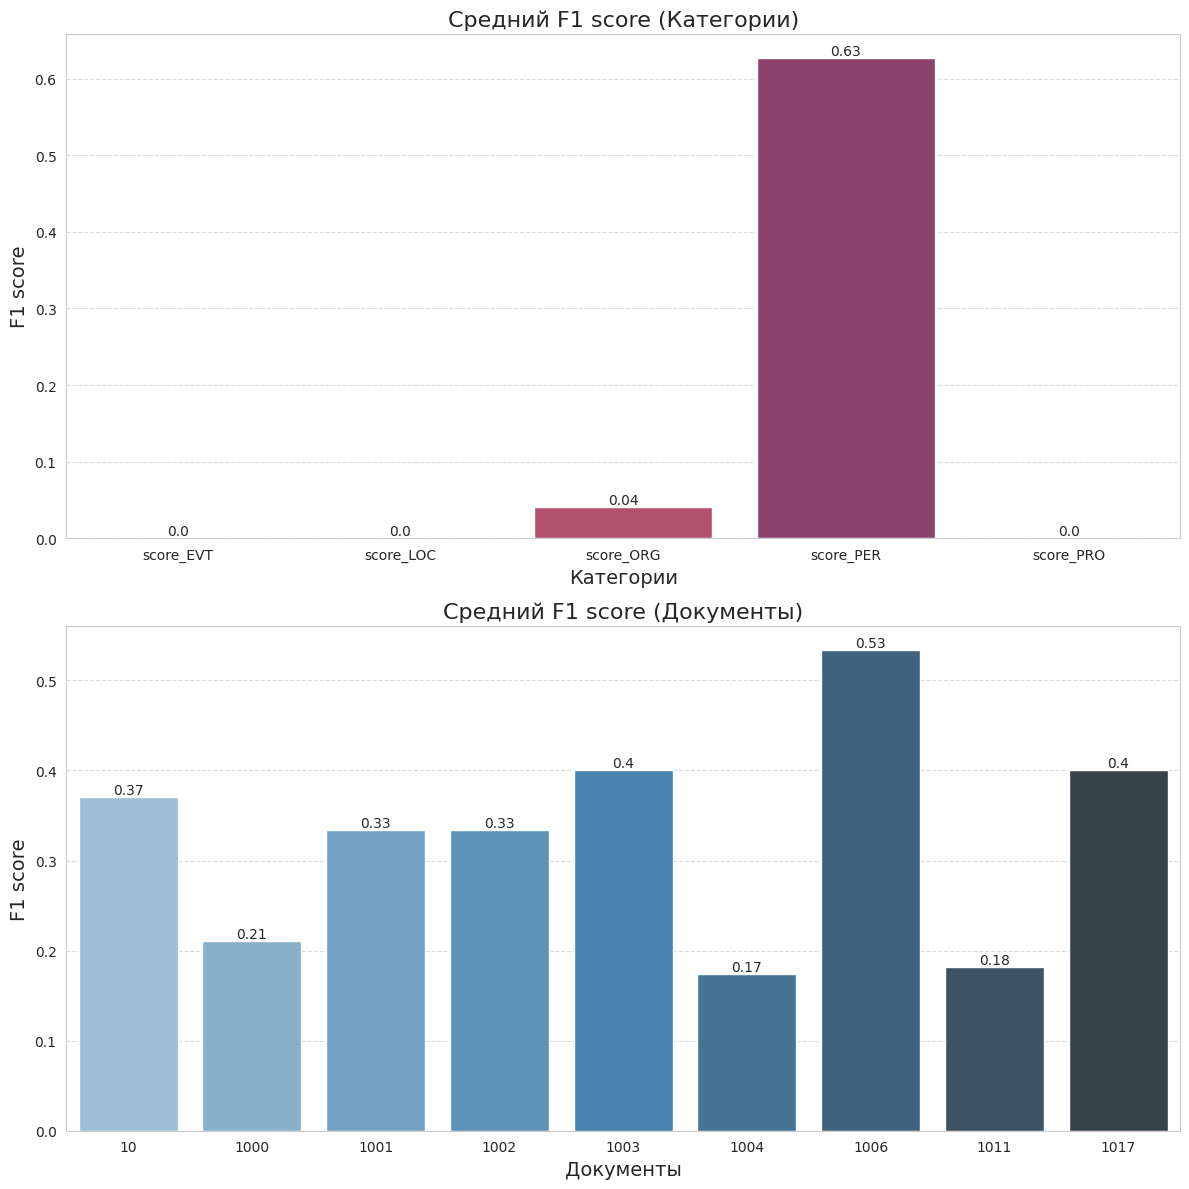

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
custom_palette = sns.color_palette("flare", len(categories))

columns = [["score_"+category for category in categories], ["score_doc", "document_id"]]
names = ["Категории", "Документы"]

fig, axes = plt.subplots(2, 1, figsize=(12, 12))
barplot1 = sns.barplot(data=statistic_df[columns[0]].mean().reset_index(), x="index", y=0, ax=axes[0], palette=custom_palette)
for index, row in statistic_df[columns[0]].mean().reset_index().iterrows():
    barplot1.annotate(round(row[0], 2), (index, row[0]), ha='center', va='bottom', fontsize=10)

barplot2 = sns.barplot(data=statistic_df[columns[1]], x="document_id", y="score_doc", ax=axes[1], palette="Blues_d")
for i, (index, row) in enumerate(statistic_df[columns[1]].sort_values('document_id').iterrows()):
    barplot2.annotate(round(row['score_doc'], 2), (i, row['score_doc']), ha='center', va='bottom', fontsize=10)

for ax, name in zip(axes, names):
    ax.set_title(f"Средний F1 score ({name})", fontsize=16)
    ax.set_xlabel(name, fontsize=14)
    ax.set_ylabel("F1 score", fontsize=14)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

Можно сделать вывод, что модель абсолютно не правильно определяет такие сущности как EVT, LOC, PRO. Но сущности типа PER определяются хорошо. С тем же можно сделать вывод, что окончательный doc_score зависит от правильности определения PER.

Так же можно заметить, что некоторые документы (1000, 1004, 1011) имеют низкий по сравнению с другими doc_score и документ 1006 имеет высокую по сравнению с другими метрику, такое поведение будет рассматриваться в **задании 8**

Так же стоит проанализировать ошибки, они также будут рассматриваться в **задании 8**

# Задание 7
**Есть ли зависимость метрик от длины документа? Постройте графики, чтобы ответить на вопрос.**

В качестве запроса в GigaChat использовался не весь текст, а по предложениям, поэтому здраво оценить зависимость длины целого документа от метрик не получится.

Так же оценить метрики от размера предложения затруднительно, так как результаты запросов соединяются.

Причины такой структуры запросов можно почитать в **Задании 3**

Но всё таки можно построить графики

In [ ]:
df = df.join(statistic_df.set_index("document_id"), on = ["document_id"])

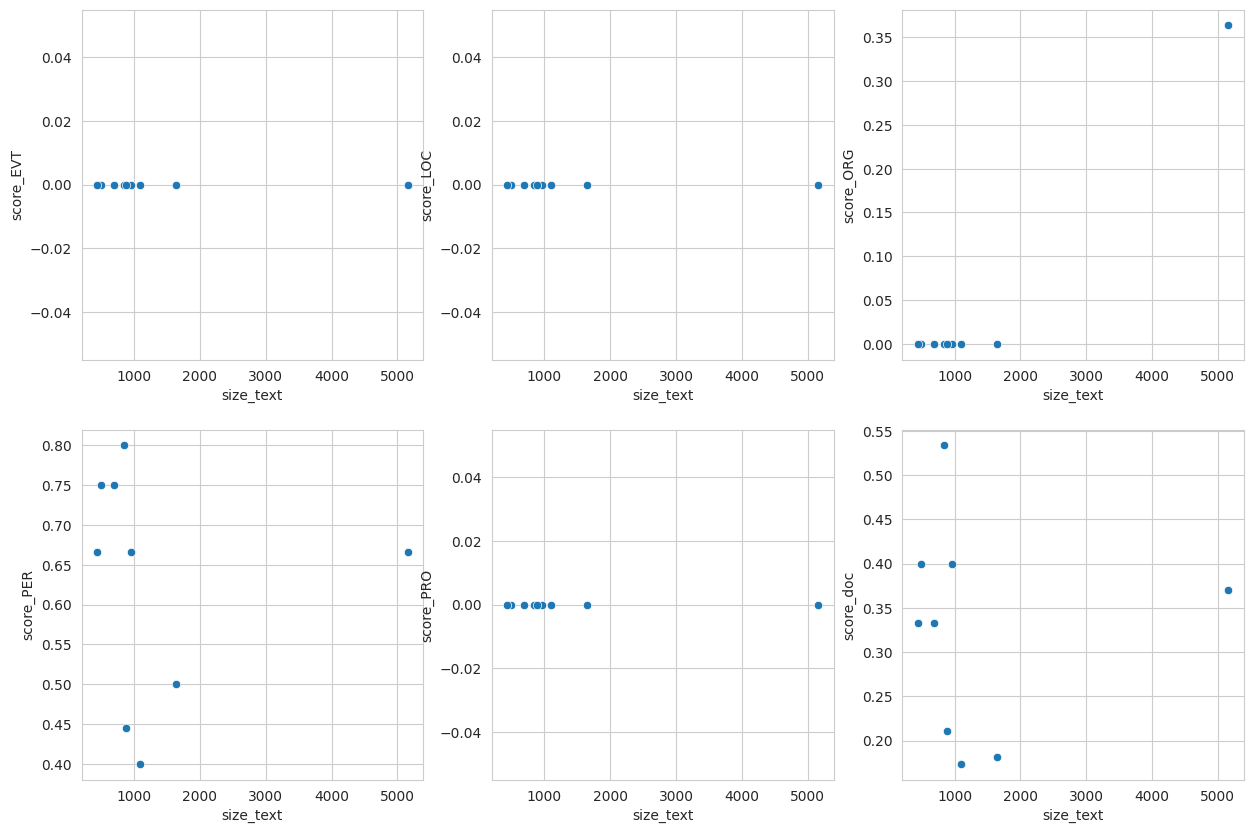

In [ ]:
df["size_text"] = df["document_text"].apply(lambda text: len(text))

fig, axes = plt.subplots(2, 3, figsize = (15, 10))
columns = ["score_"+category for category in categories] + ["score_doc"]

for row in range(2):
    for col in range(3):
        sns.scatterplot(data = df, x = "size_text", y = columns[(row*3) + col], ax = axes[row][col])

plt.show()

В данном случае, можно сказать, что зависимости метрики от длины документа нет

#Задание 8
**Проведите анализ ошибок. Когда модель чаще отвечает правильно, а когда ошибается? Предложите варианты, как повысить метрики.**

In [ ]:
categories = ["EVT", "LOC", "ORG", "PER", "PRO"]


error_df = pd.DataFrame.from_dict(errors)
error_df.rename(columns = {category:"error_"+category for category in categories}, inplace = True)
error_df["document_id"] = df["document_id"]
statistic_df = statistic_df.join(error_df.set_index("document_id"), on = "document_id")
statistic_df

,score_EVT,score_LOC,score_ORG,score_PER,score_PRO,score_doc,document_id,error_EVT,error_LOC,error_ORG,error_PER,error_PRO,error_doc
0,0.0,0.0,0.000000,0.666667,0.0,0.400000,1017,1.000000,1.0,1.0,0.142857,1.0,0.142857
1,0.0,0.0,0.000000,0.750000,0.0,0.400000,1003,2.000000,1.0,1.0,0.000000,1.0,0.200000
2,0.0,0.0,0.000000,0.800000,0.0,0.533333,1006,1.000000,1.0,1.0,0.000000,1.0,0.000000
3,0.0,0.0,0.363636,0.666667,0.0,0.370370,10,0.666667,1.0,1.0,0.714286,0.0,0.629630
4,0.0,0.0,0.000000,0.666667,0.0,0.333333,1002,1.000000,1.0,0.5,0.333333,1.0,0.428571
5,0.0,0.0,0.000000,0.400000,0.0,0.173913,1004,2.000000,1.0,1.0,0.142857,1.0,0.166667
6,0.0,0.0,0.000000,0.500000,0.0,0.181818,1011,8.000000,1.0,1.0,0.000000,1.0,0.666667
7,0.0,0.0,0.000000,0.444444,0.0,0.210526,1000,3.000000,1.0,1.0,0.166667,1.0,0.307692
8,0.0,0.0,0.000000,0.750000,0.0,0.333333,1001,2.000000,1.0,1.0,0.000000,1.0,0.153846


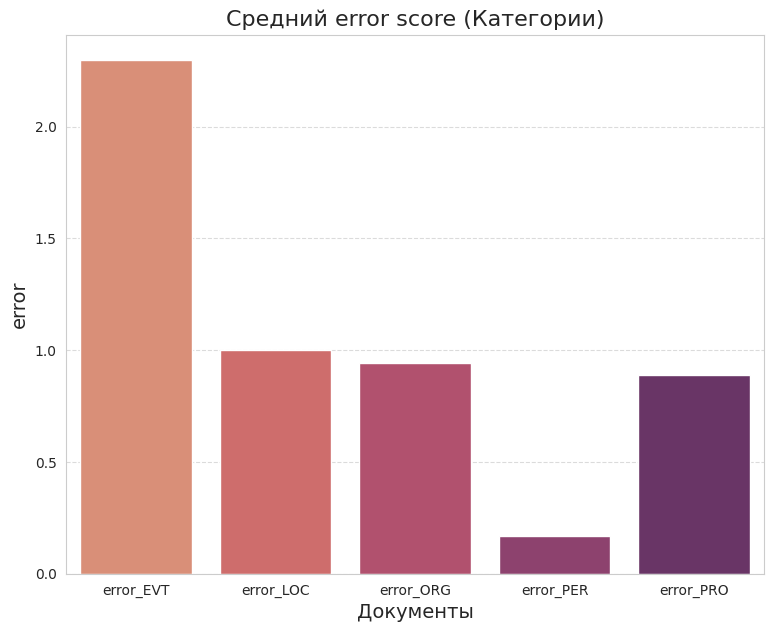

In [ ]:
fig = plt.figure(figsize = (9, 7))

columns = ["error_"+category for category in categories]

sns.barplot(data=statistic_df[columns].mean().reset_index(), x="index", y=0, palette=custom_palette)
for index, row in statistic_df[columns].mean().reset_index().iterrows():
    barplot1.annotate(round(row[0], 2), (index, row[0]), ha='center', va='bottom', fontsize=10)

plt.title(f"Средний error score (Категории)", fontsize=16)
plt.xlabel(name, fontsize=14)
plt.ylabel("error", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

Как можно видеть, модель точно определяет сущности типа PER, но

находит достаточно много ложных сущностей типа EVT, например, "EVT_отставка Мэй". Можно сказать, что модель не совсем понимает отличие просто эвента (действия) и именовонного эвента типа EVT_Brexit. \
Так же модель абсолютно не находит сущности типа LOC и PRO, тут уже сложнее понять почему такое происходит.

In [ ]:
bad_document_ids = list(df[statistic_df["score_doc"] < 0.3]["document_id"].index)
bad_document = statistic_df.loc[bad_document_ids]
bad_document["error_EVT"].mean()

4.333333333333333

In [ ]:
good_document_ids = list(statistic_df[statistic_df["score_doc"] >= 0.3]["document_id"].index)
good_document = statistic_df.loc[good_document_ids]
good_document["error_EVT"].mean()

1.277777777777778

Стоит отметить, что именно документы с низким score_doc (< 0.3) как раз имеют очень большие ошибки в категории EVT, а документы с score_doc (> 0.3) имеют ошибку в EVT на единицы меньше

Стоит отметить ещё один документ, который выделяется на фоне остальных, документ у которого есть score_ORG и довольно большой error_PER - это документ с id 10

In [ ]:
df[df["document_id"] == 10]

,Unnamed: 0,document_id,document_text,entity,gold_answer,predict,score_EVT,score_LOC,score_ORG,score_PER,score_PRO,score_doc,size_text
3,3,10,Тереза Мэй рассчитывает усидеть в седле до зав...,"EVT, LOC, ORG, PER","EVT_Brexit, EVT_брекзит, EVT_брексит, LOC_Альб...","EVT_непредсказуемое будущее, EVT_утверждение с...",0.0,0.0,0.363636,0.666667,0.0,0.37037,5161


In [ ]:
statistic_df[statistic_df["document_id"] == 10]

,score_EVT,score_LOC,score_ORG,score_PER,score_PRO,score_doc,document_id,error_EVT,error_LOC,error_ORG,error_PER,error_PRO,error_doc
3,0.0,0.0,0.363636,0.666667,0.0,0.37037,10,0.666667,1.0,1.0,0.714286,0.0,0.62963


In [ ]:
print(list(df[df["document_id"] == 10]["predict"]))
print(list(df[df["document_id"] == 10]["gold_answer"]))

['EVT_непредсказуемое будущее, EVT_утверждение сделки, ORG_Британия, ORG_Брюссель, ORG_Джонсон, ORG_Еврокомиссия, ORG_Европейские СМИ, ORG_Европейский парламент, ORG_Евросоюз, ORG_Лондон, ORG_Международный валютный фонд, ORG_Мэй, ORG_британские букмекерские конторы, ORG_британский парламент, ORG_британский премьер, PER_Борис Джонсон, PER_Джонсон, PER_Лондон, PER_Мишель Барнье, PER_Мэй, PER_Ред, PER_Тереза, PER_Тереза Мэй, PER_британцы, PER_бывший министр иностранных дел, PER_консерваторы, PRO_фунты стерлингов']
['EVT_Brexit, EVT_брекзит, EVT_брексит, LOC_Альбион, LOC_Британия, LOC_Брюссель, LOC_Европа, LOC_Ла-Манш, LOC_Лондон, LOC_Северная Ирландия, LOC_Соединенное Королевство, ORG_ЕС, ORG_Еврокомиссия, ORG_Европейский, ORG_Евросоюз, ORG_Консервативная партия, ORG_Международный валютный фонд, ORG_британский парламент, ORG_лейборист, ORG_тори, PER_Борис Джонсон, PER_Джонсон, PER_Мишель Барнье, PER_Мэй, PER_Себастьян Курц, PER_Тереза, PER_Тереза Мэй']


Данный документ отличается тем, что метки из gold_answer не стандартизированы, поэтому можно заметить, что error_PER и общий score_doc отличается для данного документа, это замечание добавляет ещё один + за стандартизацию

In [ ]:
categories = ["EVT", "LOC", "ORG", "PER", "PRO"]
matrix_errors = {category_1:{category_2:0 for category_2 in categories} for category_1 in categories}
size_one_annot = 3
for index, row in df.iterrows():
    gold_answer = row["gold_answer"].split(", ")
    dict_gold_answer = {category:[] for category in categories}
    for gold in gold_answer:
        dict_gold_answer[gold[:size_one_annot]].append(gold)

    predict = row["predict"].split(", ")
    dict_predict_answer = {category:[] for category in categories}
    for pred in predict:
        if pred[:size_one_annot] not in categories:
            continue
        dict_predict_answer[pred[:size_one_annot]].append(pred)

    for category_1 in categories:
        for entity_name in dict_predict_answer[category_1]:
            for category_2 in categories:
                if category_2+entity_name[3:] in dict_gold_answer[category_2]:
                      matrix_errors[category_1][category_2] += 1

In [ ]:
pd.DataFrame.from_dict(matrix_errors)

,EVT,LOC,ORG,PER,PRO
EVT,0,0,0,0,0
LOC,0,0,4,1,0
ORG,0,0,4,0,0
PER,0,0,2,28,0
PRO,0,0,0,0,0


Можно заметить, что в некоторых случаях, LOC предсказываются как ORG и PER предсказываюся как ORG.

### Решения способствующие поднятию метрик

Одно из решений поднятия метрики может служить более тонкая настройка промпта, чтобы убрать недосказанность, что означает EVT(событие).

Ещё одним решением является стандартизация меток, чтобы уточнить, что имеется ввиду, то напишу пример: "отставка Мэй" -> PER_Тереза Мэй, т.е. по контексту модель должна понимать, что Мэй это конкретная Тереза Мэй. Но для этого необходимо подавать в модель весь текст, а не по предложениям, что опять может привезти к проблеме описанной в задании 3 - модель может написать, что это неудобная тема и не выдать ответ.

Возможно, метрики могут подняться после предобработки исходных текстов: таких как удаление stop_word (предлоги, служебные частицы и др), так же привести слова в  нормальные словоформы, удаление знаков препинания.

Так же нужны дополнительные исследования с разными промптами и настройками модели. ($\quad$ У меня закончились бесплатные токены:( $\quad$)

# Задание 9
**Сделайте выводы по всему исследованию. Напишите, чему научились и что нового попробовали.**


**ВЫВОДЫ**:\
В данной работе исследовалось как LLM, а именно GigaChat, могут решать задачу NER - детекция именованных сущностей в тексте. Были даны 9 новостных текстов про Brexit. Были выявлены некоторые проблемы при решении данной задачи в связи с документами:

Так как даны новостные политические статьи, то в них могут присутствовать стоп слова, которые GigaChat не может анализировать и следовательно забраковать целую статью, не выдая ответ вовсе. Решением данной проблемы стало использование в качестве запроса не весь текст новости, а по предложениям, такое решение позволяет предложения со стоп-словами не анализировать, но другие могут быть проанализированы, что позволяет анализировать все статьи.

В ходе работы были выявлены сущности, которые модель находит хорошо, а какие плохо:

Выяснилось, что при выбранном промпте, сущности типа EVT обнаруживались в корне не правильно, детектировались главные действия в предложении, но не именованные события. Например, EVT_отставка Мэй, в данном примере есть событие - отставка Мэй, но нет именованного события. Пример именованных событий может быть "EVT_Comic One", "EVT_The Game Awards 2023". Одно из решением данной проблемы может быть переформулировка метки EVT в промпте, например не события, а мероприятия.\
Очень хорошо находились сущности типа PER.\
Некоторым именованным сущностям были проставлены неверные метки, например, "ORG_Великобритания" вместо "LOC_Великобритания", такое поведение я объяснить не в силах. Возможное решение могло быть в переформулировке промпта.

Следующие эксперименты, которые могут поднять метрики:
предобработка исходных текстов: таких как удаление stop_word (предлоги, служебные частицы и др), так же привести слова в нормальные словоформы, удаление знаков препинания, использование других формулировок связанных с меткой EVT

**ЧТО НОВОГО ПОПРОБОВАЛ?**\
В ходе выполнения данного задания я ближе познакомился с задачей NER - детекцией именованных сущностей, я знал о существовании данной задачи в NLP, но не выполнял заданий на эту тему, поэтому такое задание дало мне большее понимания задачи и общих проблем связанных с этим.

Так же в задаче предполагалось ручная разметка текстов, но я решил использовать готовое решение - gigachain/gigachat, которое позволяет написать код на Python, который в свою очередь может автоматически отправлять запросы в GigaChat для анализа предложенных текстов ($\quad$ было потрачено 1.5 млн токенов :( $\quad$). Возможно, в будущих своих проектах я уже буду использовать GigaChat